# Risk Premiums from Fama-Macbeth Cross-sectional Regression

- pandas datareader, Fama French data library

Terence Lim

In [1]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pandas_datareader as pdr
from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader
from finds.database import SQL, Redis
from finds.structured import CRSP, Signals, Benchmarks
from finds.busday import BusDay
from finds.backtesting import RiskPremium
from finds.solve import winsorized
from settings import settings
LAST_DATE = settings['crsp+date']
sql = SQL(**settings['sql'])
user = SQL(**settings['user'])
rdb = Redis(**settings['redis'])
bd = BusDay(sql)
crsp = CRSP(sql, bd, rdb)
bench = Benchmarks(sql, bd)
signals = Signals(user)
logdir = os.path.join(settings['images'], 'fm')

### Helper to compute least square coefs, supports groupby().apply

In [2]:
def least_squares(data=None, y=['y'], x=['x'], stdres=False):
    """Helper to compute least square coefs, supports groupby().apply"""
    X = data[x].to_numpy()
    Y = data[y].to_numpy()
    X = np.hstack([np.ones((X.shape[0], 1)), X])
    x = ['Intercept'] + x
    b = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y)).T
    if stdres:
        b = np.hstack([b, np.std(Y-(X @ b.T), axis=0).reshape(-1,1)])
        x = x + ['stdres']
    return (DataFrame(b, columns=x, index=y) if len(b) > 1 else
            Series(b[0], x))   # return as Series for groupby.apply

## Retrieve market and test asset returns

In [3]:
mkt = FamaFrenchReader('F-F_Research_Data_Factors', start=1900, end=2099).read()
mkt = mkt[0].rename(columns={'Mkt-RF': 'BETA'})
asset_names = ['25_Portfolios_ME_BETA_5x5',
               '25_Portfolios_ME_VAR_5x5',
               '25_Portfolios_ME_RESVAR_5x5',
               '25_Portfolios_5x5']
test_assets = {asset: FamaFrenchReader(asset, start=1900, end=2099).read()
               for asset in asset_names}

## Fama-MacBeth regressions with 5x5 test assets and estimated loadings 

In [4]:
for asset in asset_names:
    for p, wt in enumerate(['Value-weighted', 'Equal-weighted']):
        f = test_assets[asset][p]
        
        # subtract riskfree and stack data as thin dataframe
        df = f.sub(mkt['RF'], axis=0).dropna().copy()
        rets = df.stack().reset_index(name='ret')\
                         .rename(columns={'level_1':'port', 'level_0':'Date'})

        # estimate test assets market betas from time-series of returns
        data = df.join(mkt[['BETA']], how='left')
        betas = least_squares(data, y=df.columns, x=['BETA'],
                         stdres=True)[['BETA', 'stdres']]  # emits stdres too
        
        # orthogonalize beta^2 and residual-volatility regressors
        betas['BETA2'] = smf.ols("I(BETA**2) ~ BETA", data=betas).fit().resid
        betas['RES'] = smf.ols("stdres ~ BETA", data=betas).fit().resid
        r = rets.join(betas, on='port').sort_values(['port',     # join returns
                                                     'Date'], ignore_index=True)

        # run monthly Fama MacBeth cross-sectional regressions
        print(asset, wt, r['Date'].iloc[0], '-', r['Date'].iloc[-1])
        fm = r.groupby(by='Date')\
              .apply(least_squares, y=['ret'], x=['BETA', 'BETA2', 'RES'])
        print(DataFrame({'mean': fm.mean(), 'stderr': fm.sem(),
                         'tvalue': fm.mean() / fm.sem()}).T.round(4))
        print()

25_Portfolios_ME_BETA_5x5 Value-weighted 196307 - 202101
        Intercept    BETA   BETA2     RES
mean       0.6865  0.0726 -1.1325  0.1309
stderr     0.1632  0.2390  0.3452  0.0721
tvalue     4.2051  0.3037 -3.2811  1.8160

25_Portfolios_ME_BETA_5x5 Equal-weighted 196307 - 202101
        Intercept    BETA   BETA2     RES
mean       0.8191  0.0018 -1.0855  0.1586
stderr     0.1569  0.2310  0.2958  0.0632
tvalue     5.2216  0.0077 -3.6703  2.5095

25_Portfolios_ME_VAR_5x5 Value-weighted 196307 - 202101
        Intercept    BETA   BETA2     RES
mean       1.0584 -0.2741 -1.8542  0.0666
stderr     0.1921  0.2573  0.3421  0.0693
tvalue     5.5094 -1.0652 -5.4204  0.9600

25_Portfolios_ME_VAR_5x5 Equal-weighted 196307 - 202101
        Intercept    BETA   BETA2     RES
mean       1.0002 -0.1729 -1.5833  0.1062
stderr     0.1889  0.2536  0.2711  0.0576
tvalue     5.2955 -0.6817 -5.8412  1.8425

25_Portfolios_ME_RESVAR_5x5 Value-weighted 196307 - 202101
        Intercept    BETA   BETA2     R

## Post-1963 time-period

In [5]:
data = data[data.index >= '1963-07']
betas = least_squares(data, y=df.columns, x=['BETA'],
                 stdres=True)[['BETA', 'stdres']]
betas['BETA2'] = smf.ols("I(BETA**2) ~ BETA", data=betas).fit().resid
betas['RES'] = smf.ols("stdres ~ BETA", data=betas).fit().resid
r = rets[rets['Date'] >= '1963-07'].join(betas, on='port')\
                                .sort_values(['port', 'Date'], ignore_index=True)
print(asset, wt, r['Date'].iloc[0], '-', r['Date'].iloc[-1])
fm = r.groupby(by='Date')\
      .apply(least_squares, y=['ret'], x=['BETA','BETA2','RES'])
DataFrame({'mean': fm.mean(), 'stderr': fm.sem(),
           'tvalue': fm.mean() / fm.sem()}).T.round(4)

25_Portfolios_5x5 Equal-weighted 196307 - 202101


,Intercept,BETA,BETA2,RES
mean,1.2585,-0.3968,-5.0266,0.1405
stderr,0.3647,0.3816,0.8594,0.0570
tvalue,3.4509,-1.0400,-5.8487,2.4649


## Fama MacBeth with individual stocks and standardized scores as loadings

In [18]:
rebalbeg=19640601
rebalend=LAST_DATE
rebaldates = crsp.bd.date_range(rebalbeg, rebalend, 'endmo')
loadings = dict()
for pordate in rebaldates:             # retrieve signal values every month
    date = bd.june_universe(pordate)
    univ = crsp.get_universe(date)
    cap = np.sqrt(crsp.get_cap(date)['cap'])
    smb = -np.log(cap).rename('size')
    hml = signals('hml', date, bd.endmo(date, -12))['hml'].rename('value')
    beta = (signals('beta', pordate, bd.begmo(pordate))['beta']*2/3)+(1/3)
    mom = signals('mom', pordate)['mom'].rename('momentum')
    df = pd.concat((beta, hml, smb, mom),  # inner join of signals with univ
                   join='inner', axis=1).reindex(univ.index).dropna()
    loadings[pordate] = winsorized(df, quantiles=[0.05, 0.95])

## Compute coefficients from FM cross-sectional regressions                        

In [19]:
riskpremium = RiskPremium(user, bench, 'RF', LAST_DATE)
riskpremium(crsp, loadings, weights=None, # FM regressions on standardized scores
            standardize=['value' ,'size', 'momentum'])

,beta,momentum,size,value
mean,0.007294,0.002216,0.002154,0.001815
stderr,0.002079,0.000574,0.000668,0.000374
std,0.054128,0.014940,0.017392,0.009729
count,678.000000,678.000000,678.000000,678.000000


In [20]:
df = loadings[19640630]
col='value'
(df[col] - np.average(df[col], weights=None))/np.std(df[col])

permno
10137   -0.120981
10823   -0.816249
11340    1.272437
11404    1.438717
11543    1.852920
           ...   
25283   -1.588819
25443    1.852920
25523   -0.576510
25590    1.852920
27385   -1.588819
Name: value, Length: 76, dtype: float64

## Compare to benchmarks

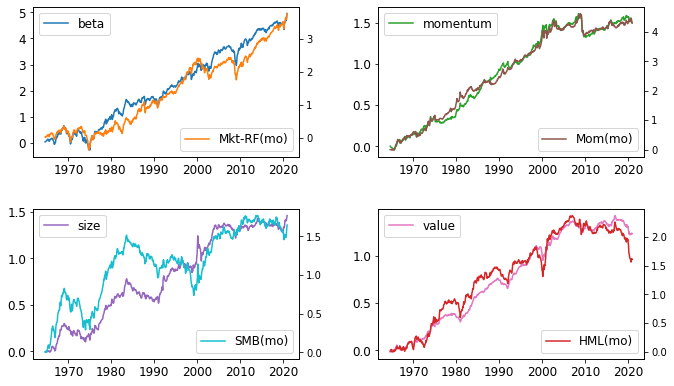

In [21]:
benchnames = {'beta': 'Mkt-RF(mo)', 'momentum': 'Mom(mo)',
              'size':'SMB(mo)', 'value': 'HML(mo)'}
out = riskpremium.fit(benchnames.values())    # compare portfolio-sort benchmarks
riskpremium.plot(benchnames)
plt.savefig(os.path.join(logdir, 'fm.jpg'))

## Summarize time-series means

In [22]:
df = out[3].join(out[0])
df.loc['tvalue'] = df.loc['mean']/df.loc['stderr']
df.loc['sharpe'] = np.sqrt(12) * df.loc['mean']/df.loc['std']
print(f'Fama MacBeth Estimated Factor and Benchmark Returns'
      f'{riskpremium.perf.index[0]}')
df

Fama MacBeth Estimated Factor and Benchmark Returns19640731


,beta,momentum,size,value,Mkt-RF(mo),Mom(mo),SMB(mo),HML(mo)
mean,0.007294,0.002216,0.002154,0.001815,0.005564,0.006325,0.002431,0.002371
stderr,0.002079,0.000574,0.000668,0.000374,0.001729,0.001631,0.001171,0.001108
std,0.054128,0.014940,0.017392,0.009729,0.045010,0.042464,0.030492,0.028845
count,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000
tvalue,3.508963,3.862686,3.224795,4.857396,3.218954,3.878602,2.075559,2.139957
sharpe,0.466826,0.513884,0.429020,0.646218,0.428243,0.516001,0.276128,0.284696


## Display correlations of returns

In [23]:
print('Correlation of Fama MacBeth Estimated Factor and Benchmark Returns')
out[4].join(out[2])

Correlation of Fama MacBeth Estimated Factor and Benchmark Returns


,beta,momentum,size,value,Mkt-RF(mo),Mom(mo),SMB(mo),HML(mo)
beta,1.000000,-0.255062,0.322456,-0.002896,0.875666,-0.287668,0.643982,-0.122100
momentum,-0.255062,1.000000,-0.135689,-0.286902,-0.062397,0.842998,-0.069883,-0.252066
size,0.322456,-0.135689,1.000000,-0.164411,-0.033128,0.088829,0.572393,-0.124813
value,-0.002896,-0.286902,-0.164411,1.000000,-0.054969,-0.244092,-0.040834,0.781361
